# Modelo SVM con Preprocesado Completo

- Sergio Andres Daza
- Antonia Yepes Quintero

Este notebook implementa un modelo Support Vector Machine (SVM) utilizando el preprocesado desarrollado anteriormente.

## 1. Importar librerías necesarias

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Función de preprocesado completo

Consolidamos todo el preprocesado en una función reutilizable para aplicar tanto a train como a test.

In [ ]:
def preprocesar_datos(df, es_train=True, scaler=None):
    df_procesado = df.copy()
    
    # 1. Identificar columnas numéricas y categóricas
    numeric_cols = df_procesado.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_procesado.select_dtypes(include='object').columns.tolist()
    
    # Remover ID y target de las listas si existen
    if 'ID' in numeric_cols:
        numeric_cols.remove('ID')
    if 'RENDIMIENTO_GLOBAL' in categorical_cols:
        categorical_cols.remove('RENDIMIENTO_GLOBAL')
    
    # 2. Imputación de valores nulos
    print("Aplicando imputación de valores nulos...")
    for col in numeric_cols:
        if df_procesado[col].isnull().sum() > 0:
            df_procesado[col].fillna(df_procesado[col].mean(), inplace=True)
    
    for col in categorical_cols:
        if df_procesado[col].isnull().sum() > 0:
            df_procesado[col].fillna(df_procesado[col].mode()[0], inplace=True)
    
    # 3. Procesar RENDIMIENTO_GLOBAL solo si es train
    if es_train and 'RENDIMIENTO_GLOBAL' in df_procesado.columns:
        print("Procesando variable target...")
        mapeo_rendimiento = {
            'bajo': 0,
            'medio-bajo': 1,
            'medio-alto': 2,
            'alto': 3
        }
        df_procesado['RENDIMIENTO_GLOBAL'] = df_procesado['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)
    
    # 4. Procesar ESTU_HORASSEMANATRABAJA
    print("Procesando horas de trabajo...")
    def procesar_horas_trabajo(valor):
        if pd.isnull(valor):
            return None
        valor = str(valor).strip()
        if valor == "0":
            return 0
        elif "Menos de" in valor:
            numeros = re.findall(r'\d+', valor)
            return int(numeros[0]) if numeros else 0
        elif "Más de" in valor:
            numeros = re.findall(r'\d+', valor)
            return int(numeros[0]) if numeros else 30
        else:
            numeros = re.findall(r'\d+', valor)
            if len(numeros) == 2:
                return int((int(numeros[0]) + int(numeros[1])) / 2)
            elif len(numeros) == 1:
                return int(numeros[0])
            else:
                return 0
    
    df_procesado['ESTU_HORASSEMANATRABAJA'] = df_procesado['ESTU_HORASSEMANATRABAJA'].apply(procesar_horas_trabajo)
    
    # 5. Procesar ESTU_VALORMATRICULAUNIVERSIDAD
    print("Procesando valor matrícula...")
    def extraer_promedio(valor_str):
        numeros = re.findall(r"(\d+\.*\d*)", str(valor_str))
        if len(numeros) >= 2:
            min_val = float(numeros[0])
            max_val = float(numeros[1])
            return (min_val + max_val) / 2
        else:
            return np.nan
    
    df_procesado['ESTU_VALORMATRICULAUNIVERSIDAD'] = df_procesado['ESTU_VALORMATRICULAUNIVERSIDAD'].apply(extraer_promedio)
    
    # 6. Procesar FAMI_ESTRATOVIVIENDA
    print("Procesando estrato vivienda...")
    df_procesado['FAMI_ESTRATOVIVIENDA'] = df_procesado['FAMI_ESTRATOVIVIENDA'].str.lower().str.replace('estrato', '').str.strip()
    df_procesado['FAMI_ESTRATOVIVIENDA'] = df_procesado['FAMI_ESTRATOVIVIENDA'].replace('sin', '0')
    df_procesado['FAMI_ESTRATOVIVIENDA'] = df_procesado['FAMI_ESTRATOVIVIENDA'].astype(int)
    
    # 7. Procesar variables binarias
    print("Procesando variables binarias...")
    if 'FAMI_TIENEINTERNET' in df_procesado.columns:
        df_procesado['FAMI_TIENEINTERNET'] = df_procesado['FAMI_TIENEINTERNET'].map({'Si': 1, 'No': 0})
    if 'ESTU_PAGOMATRICULAPROPIO' in df_procesado.columns:
        df_procesado['ESTU_PAGOMATRICULAPROPIO'] = df_procesado['ESTU_PAGOMATRICULAPROPIO'].map({'Si': 1, 'No': 0})
    
    # 8. Label encoding para educación (manteniendo orden jerárquico)
    print("Aplicando label encoding ordenado...")
    orden_educacion = [
        "No aplica", "No sabe", "Ninguno", "Primaria incompleta", "Primaria completa",
        "Secundaria (Bachillerato) incompleta", "Secundaria (Bachillerato) completa",
        "Técnica o tecnológica incompleta", "Técnica o tecnológica completa",
        "Educación profesional incompleta", "Educación profesional completa", "Postgrado"
    ]
    educacion_map = {nivel: idx for idx, nivel in enumerate(orden_educacion)}
    
    if 'FAMI_EDUCACIONPADRE' in df_procesado.columns:
        df_procesado['FAMI_EDUCACIONPADRE'] = df_procesado['FAMI_EDUCACIONPADRE'].map(educacion_map)
    if 'FAMI_EDUCACIONMADRE' in df_procesado.columns:
        df_procesado['FAMI_EDUCACIONMADRE'] = df_procesado['FAMI_EDUCACIONMADRE'].map(educacion_map)
    
    # 9. One-hot encoding para departamentos
    print("Aplicando one-hot encoding para departamentos...")
    if 'ESTU_PRGM_DEPARTAMENTO' in df_procesado.columns:
        df_procesado = pd.get_dummies(df_procesado, columns=['ESTU_PRGM_DEPARTAMENTO'], drop_first=True, dtype=int)
    
    # 10. Agrupar programas académicos poco frecuentes
    print("Procesando programas académicos...")
    if 'ESTU_PRGM_ACADEMICO' in df_procesado.columns:
        if es_train:
            frecuencias = df_procesado['ESTU_PRGM_ACADEMICO'].value_counts()
            umbral = 50
            programas_comunes = frecuencias[frecuencias > umbral].index
            # Guardar programas comunes para uso en test
            global programas_comunes_global
            programas_comunes_global = programas_comunes
        else:
            # Usar programas comunes del train
            programas_comunes = programas_comunes_global
        
        df_procesado['ESTU_PRGM_ACADEMICO'] = df_procesado['ESTU_PRGM_ACADEMICO'].apply(
            lambda x: x if x in programas_comunes else 'OTRO'
        )
        df_procesado = pd.get_dummies(df_procesado, columns=['ESTU_PRGM_ACADEMICO'], drop_first=True, dtype=int)
    
    # 11. Procesar PERIODO
    print("Procesando periodo...")
    if 'PERIODO' in df_procesado.columns:
        df_procesado['PERIODO'] = df_procesado['PERIODO'].astype(str)
        df_procesado['PERIODO_ANO'] = df_procesado['PERIODO'].str[:4].astype(int)
        df_procesado['PERIODO_NUM'] = df_procesado['PERIODO'].str[-1].astype(int)
        df_procesado.drop('PERIODO', axis=1, inplace=True)
    
    # 12. Normalización
    print("Aplicando normalización...")
    columnas_a_normalizar = [
        'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
        'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE',
        'PERIODO_ANO', 'PERIODO_NUM'
    ]
    
    # Filtrar solo las columnas que existen
    columnas_existentes = [col for col in columnas_a_normalizar if col in df_procesado.columns]
    
    if es_train:
        scaler = StandardScaler()
        df_procesado[columnas_existentes] = scaler.fit_transform(df_procesado[columnas_existentes])
    else:
        df_procesado[columnas_existentes] = scaler.transform(df_procesado[columnas_existentes])
    
    # 13. Remover ID si existe y es entrenamiento
    if 'ID' in df_procesado.columns and es_train:
        df_procesado.drop('ID', axis=1, inplace=True)
    
    print(f"Preprocesado completado. Shape final: {df_procesado.shape}")
    
    if es_train:
        return df_procesado, scaler
    else:
        return df_procesado

print("Función de preprocesado definida")

Función de preprocesado definida


## 3. Cargar y preprocesar datos de entrenamiento

In [4]:
# Cargar datos de entrenamiento
print("Cargando datos de entrenamiento...")
df_train = pd.read_csv("train.csv")

print(f"Datos originales - Filas: {df_train.shape[0]}, Columnas: {df_train.shape[1]}")
print(f"Distribución de clases en datos originales:")
print(df_train['RENDIMIENTO_GLOBAL'].value_counts().sort_index())

# Aplicar preprocesado
df_procesado, scaler_entrenamiento = preprocesar_datos(df_train, es_train=True)

print(f"\nDatos procesados - Filas: {df_procesado.shape[0]}, Columnas: {df_procesado.shape[1]}")
print(f"Distribución de clases después del preprocesado:")
print(df_procesado['RENDIMIENTO_GLOBAL'].value_counts().sort_index())

Cargando datos de entrenamiento...
Datos originales - Filas: 692500, Columnas: 12
Distribución de clases en datos originales:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64
Aplicando imputación de valores nulos...
Procesando variable target...
Procesando horas de trabajo...
Procesando valor matrícula...
Procesando estrato vivienda...
Procesando variables binarias...
Aplicando label encoding ordenado...
Aplicando one-hot encoding para departamentos...
Procesando programas académicos...
Procesando periodo...
Aplicando normalización...
Preprocesado completado. Shape final: (692500, 669)

Datos procesados - Filas: 692500, Columnas: 669
Distribución de clases después del preprocesado:
RENDIMIENTO_GLOBAL
0    172987
1    172275
2    171619
3    175619
Name: count, dtype: int64


## 4. Análisis exploratorio post-preprocesado

Valores nulos después del preprocesado:
Total de valores nulos: 178952

Columnas con valores nulos:
ESTU_VALORMATRICULAUNIVERSIDAD    167805
FAMI_EDUCACIONPADRE                 9229
FAMI_EDUCACIONMADRE                 1918
dtype: int64


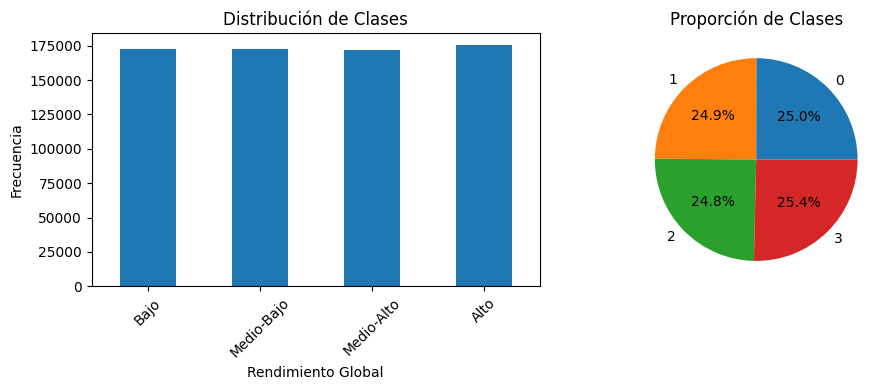


Balance de clases:
Bajo: 0.250 (25.0%)
Medio-Bajo: 0.249 (24.9%)
Medio-Alto: 0.248 (24.8%)
Alto: 0.254 (25.4%)


In [5]:
# Verificar valores nulos después del preprocesado
print("Valores nulos después del preprocesado:")
nulos_totales = df_procesado.isnull().sum().sum()
print(f"Total de valores nulos: {nulos_totales}")

if nulos_totales > 0:
    print("\nColumnas con valores nulos:")
    columnas_con_nulos = df_procesado.isnull().sum()
    print(columnas_con_nulos[columnas_con_nulos > 0])

# Análisis de la distribución de clases
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df_procesado['RENDIMIENTO_GLOBAL'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Clases')
plt.xlabel('Rendimiento Global')
plt.ylabel('Frecuencia')
plt.xticks([0, 1, 2, 3], ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'], rotation=45)

plt.subplot(1, 2, 2)
proporciones = df_procesado['RENDIMIENTO_GLOBAL'].value_counts(normalize=True).sort_index()
proporciones.plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporción de Clases')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"\nBalance de clases:")
for i, prop in enumerate(proporciones):
    clases = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
    print(f"{clases[i]}: {prop:.3f} ({prop*100:.1f}%)")

## 5. Preparación de datos para el modelo

In [6]:
# Separar features y target
X = df_procesado.drop(['RENDIMIENTO_GLOBAL'], axis=1)
y = df_procesado['RENDIMIENTO_GLOBAL']

print(f"Dimensiones finales:")
print(f"X (features): {X.shape}")
print(f"y (target): {y.shape}")

# División train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDivisión de datos:")
print(f"Training: {X_train.shape[0]} muestras")
print(f"Validation: {X_val.shape[0]} muestras")

# Verificar distribución en cada conjunto
print(f"\nDistribución en training:")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\nDistribución en validation:")
print(y_val.value_counts(normalize=True).sort_index())

Dimensiones finales:
X (features): (692500, 668)
y (target): (692500,)

División de datos:
Training: 554000 muestras
Validation: 138500 muestras

Distribución en training:
RENDIMIENTO_GLOBAL
0    0.249801
1    0.248773
2    0.247825
3    0.253601
Name: proportion, dtype: float64

Distribución en validation:
RENDIMIENTO_GLOBAL
0    0.249798
1    0.248773
2    0.247827
3    0.253603
Name: proportion, dtype: float64


## 5.1. Verificación y limpieza final de valores NaN

Antes de la selección de características, verificamos y limpiamos cualquier valor NaN restante.


In [7]:
print("=== VERIFICACIÓN Y LIMPIEZA DE VALORES NaN ===")

# Verificar valores NaN en el conjunto de entrenamiento
print(f"\nVerificación de NaN en datos de entrenamiento:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Contar NaN por columna
nan_counts_train = X_train.isnull().sum()
nan_counts_val = X_val.isnull().sum()

print(f"\nColumnas con NaN en X_train:")
columnas_con_nan_train = nan_counts_train[nan_counts_train > 0]
if len(columnas_con_nan_train) > 0:
    print(columnas_con_nan_train)
else:
    print("No hay columnas con NaN en X_train")

print(f"\nColumnas con NaN en X_val:")
columnas_con_nan_val = nan_counts_val[nan_counts_val > 0]
if len(columnas_con_nan_val) > 0:
    print(columnas_con_nan_val)
else:
    print("No hay columnas con NaN en X_val")

# Total de NaN
total_nan_train = X_train.isnull().sum().sum()
total_nan_val = X_val.isnull().sum().sum()
print(f"\nTotal NaN en X_train: {total_nan_train}")
print(f"Total NaN en X_val: {total_nan_val}")

# Si hay NaN, aplicar estrategias de limpieza
if total_nan_train > 0 or total_nan_val > 0:
    print("\n🔧 APLICANDO LIMPIEZA DE NaN...")
    
    # Identificar columnas numéricas y categóricas restantes
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()
    
    print(f"Columnas numéricas: {len(numeric_features)}")
    print(f"Columnas categóricas: {len(categorical_features)}")
    
    # Limpiar columnas numéricas con NaN
    for col in numeric_features:
        if X_train[col].isnull().sum() > 0:
            print(f"Limpiando {col}: {X_train[col].isnull().sum()} NaN en train")
            
            # Usar la mediana para ser más robusto contra outliers
            fill_value = X_train[col].median()
            if pd.isna(fill_value):  # Si la mediana también es NaN, usar 0
                fill_value = 0
                
            X_train[col] = X_train[col].fillna(fill_value)
            X_val[col] = X_val[col].fillna(fill_value)
    
    # Limpiar columnas categóricas con NaN
    for col in categorical_features:
        if X_train[col].isnull().sum() > 0:
            print(f"Limpiando {col}: {X_train[col].isnull().sum()} NaN en train")
            
            # Usar la moda, si no existe usar 'unknown'
            mode_values = X_train[col].mode()
            if len(mode_values) > 0:
                fill_value = mode_values[0]
            else:
                fill_value = 'unknown' if X_train[col].dtype == 'object' else 0
                
            X_train[col] = X_train[col].fillna(fill_value)
            X_val[col] = X_val[col].fillna(fill_value)
    
    # Verificación final
    print(f"\n✅ VERIFICACIÓN POST-LIMPIEZA:")
    final_nan_train = X_train.isnull().sum().sum()
    final_nan_val = X_val.isnull().sum().sum()
    print(f"NaN restantes en X_train: {final_nan_train}")
    print(f"NaN restantes en X_val: {final_nan_val}")
    
    if final_nan_train == 0 and final_nan_val == 0:
        print("🎉 ¡Todos los NaN han sido eliminados!")
    else:
        print("⚠️ Aún quedan algunos NaN - revisión manual necesaria")
        
        # Mostrar qué columnas aún tienen NaN
        remaining_nan_cols_train = X_train.columns[X_train.isnull().any()].tolist()
        remaining_nan_cols_val = X_val.columns[X_val.isnull().any()].tolist()
        
        if remaining_nan_cols_train:
            print(f"Columnas con NaN en train: {remaining_nan_cols_train}")
        if remaining_nan_cols_val:
            print(f"Columnas con NaN en val: {remaining_nan_cols_val}")

else:
    print("✅ No hay valores NaN - continuando con selección de características")

# Verificar tipos de datos
print(f"\nTipos de datos en X_train:")
print(X_train.dtypes.value_counts())

# Verificar si hay valores infinitos
inf_count_train = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
inf_count_val = np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum()
print(f"\nValores infinitos en X_train: {inf_count_train}")
print(f"Valores infinitos en X_val: {inf_count_val}")

if inf_count_train > 0 or inf_count_val > 0:
    print("🔧 Reemplazando valores infinitos...")
    # Reemplazar infinitos con valores muy grandes pero finitos
    X_train = X_train.replace([np.inf, -np.inf], [1e6, -1e6])
    X_val = X_val.replace([np.inf, -np.inf], [1e6, -1e6])
    print("✅ Valores infinitos reemplazados")

print("\n" + "="*50)
print("LIMPIEZA DE DATOS COMPLETADA")
print("="*50)

=== VERIFICACIÓN Y LIMPIEZA DE VALORES NaN ===

Verificación de NaN en datos de entrenamiento:
X_train shape: (554000, 668)
X_val shape: (138500, 668)

Columnas con NaN en X_train:
ESTU_VALORMATRICULAUNIVERSIDAD    134383
FAMI_EDUCACIONPADRE                 7425
FAMI_EDUCACIONMADRE                 1552
dtype: int64

Columnas con NaN en X_val:
ESTU_VALORMATRICULAUNIVERSIDAD    33422
FAMI_EDUCACIONPADRE                1804
FAMI_EDUCACIONMADRE                 366
dtype: int64

Total NaN en X_train: 143360
Total NaN en X_val: 35592

🔧 APLICANDO LIMPIEZA DE NaN...
Columnas numéricas: 668
Columnas categóricas: 0
Limpiando ESTU_VALORMATRICULAUNIVERSIDAD: 134383 NaN en train
Limpiando FAMI_EDUCACIONPADRE: 7425 NaN en train
Limpiando FAMI_EDUCACIONMADRE: 1552 NaN en train

✅ VERIFICACIÓN POST-LIMPIEZA:
NaN restantes en X_train: 0
NaN restantes en X_val: 0
🎉 ¡Todos los NaN han sido eliminados!

Tipos de datos en X_train:
int64      661
float64      7
Name: count, dtype: int64

Valores infinitos 

## 5.2. Imputación robusta de valores NaN con sklearn

Aplicamos imputación profesional usando las herramientas de sklearn para garantizar que no queden valores NaN.


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

print("=== IMPUTACIÓN ROBUSTA DE VALORES NaN ===")

# Diagnóstico detallado inicial
print(f"\n🔍 DIAGNÓSTICO INICIAL:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

# Verificar NaN en cada conjunto
nan_train = X_train.isnull().sum().sum()
nan_val = X_val.isnull().sum().sum()
print(f"Total NaN en X_train: {nan_train}")
print(f"Total NaN en X_val: {nan_val}")

if nan_train > 0 or nan_val > 0:
    print(f"\n📊 ANÁLISIS DETALLADO DE NaN:")
    
    # Mostrar columnas con NaN y sus tipos
    nan_info = []
    for col in X_train.columns:
        nan_count_train = X_train[col].isnull().sum()
        nan_count_val = X_val[col].isnull().sum()
        if nan_count_train > 0 or nan_count_val > 0:
            dtype = str(X_train[col].dtype)
            nan_info.append({
                'Column': col,
                'Type': dtype,
                'NaN_train': nan_count_train,
                'NaN_val': nan_count_val
            })
    
    if nan_info:
        nan_df = pd.DataFrame(nan_info)
        print(nan_df)
        
        # Identificar columnas por tipo
        numeric_cols_with_nan = []
        categorical_cols_with_nan = []
        
        for col in X_train.columns:
            if X_train[col].isnull().sum() > 0 or X_val[col].isnull().sum() > 0:
                if X_train[col].dtype in ['int64', 'float64', 'int32', 'float32']:
                    numeric_cols_with_nan.append(col)
                else:
                    categorical_cols_with_nan.append(col)
        
        print(f"\nColumnas numéricas con NaN: {len(numeric_cols_with_nan)}")
        print(f"Columnas categóricas con NaN: {len(categorical_cols_with_nan)}")
        
        # Preparar imputadores
        print(f"\n🔧 APLICANDO IMPUTACIÓN SKLEARN...")
        
        # Imputador para columnas numéricas (mediana)
        if numeric_cols_with_nan:
            print(f"Imputando {len(numeric_cols_with_nan)} columnas numéricas con mediana...")
            numeric_imputer = SimpleImputer(strategy='median')
            
            # Ajustar en train y transformar ambos conjuntos
            X_train[numeric_cols_with_nan] = numeric_imputer.fit_transform(X_train[numeric_cols_with_nan])
            X_val[numeric_cols_with_nan] = numeric_imputer.transform(X_val[numeric_cols_with_nan])
        
        # Imputador para columnas categóricas (moda)
        if categorical_cols_with_nan:
            print(f"Imputando {len(categorical_cols_with_nan)} columnas categóricas con moda...")
            categorical_imputer = SimpleImputer(strategy='most_frequent')
            
            # Ajustar en train y transformar ambos conjuntos
            X_train[categorical_cols_with_nan] = categorical_imputer.fit_transform(X_train[categorical_cols_with_nan])
            X_val[categorical_cols_with_nan] = categorical_imputer.transform(X_val[categorical_cols_with_nan])

# Imputación adicional para cualquier NaN restante
print(f"\n🧹 LIMPIEZA FINAL EXHAUSTIVA...")

# Verificar si quedan NaN
remaining_nan_train = X_train.isnull().sum().sum()
remaining_nan_val = X_val.isnull().sum().sum()

if remaining_nan_train > 0 or remaining_nan_val > 0:
    print(f"⚠️ Quedan {remaining_nan_train} NaN en train y {remaining_nan_val} en val")
    print("Aplicando imputación universal...")
    
    # Imputación universal como último recurso
    universal_imputer = SimpleImputer(strategy='constant', fill_value=0)
    X_train = pd.DataFrame(
        universal_imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_val = pd.DataFrame(
        universal_imputer.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )

# Verificación final exhaustiva
print(f"\n✅ VERIFICACIÓN FINAL:")
final_nan_train = X_train.isnull().sum().sum()
final_nan_val = X_val.isnull().sum().sum()
final_inf_train = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
final_inf_val = np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum()

print(f"NaN finales en X_train: {final_nan_train}")
print(f"NaN finales en X_val: {final_nan_val}")
print(f"Infinitos en X_train: {final_inf_train}")
print(f"Infinitos en X_val: {final_inf_val}")

# Limpiar infinitos si existen
if final_inf_train > 0 or final_inf_val > 0:
    print("🔧 Limpiando valores infinitos...")
    # Reemplazar infinitos
    numeric_columns = X_train.select_dtypes(include=[np.number]).columns
    X_train[numeric_columns] = X_train[numeric_columns].replace([np.inf, -np.inf], [1e10, -1e10])
    X_val[numeric_columns] = X_val[numeric_columns].replace([np.inf, -np.inf], [1e10, -1e10])

# Verificación de tipos de datos
print(f"\n📋 RESUMEN DE TIPOS DE DATOS:")
print(f"Tipos en X_train:")
print(X_train.dtypes.value_counts())

# Convertir cualquier objeto/string a numérico si es posible
print(f"\n🔄 CONVERSIÓN DE TIPOS:")
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        try:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
            X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
            print(f"Convertido {col} a numérico")
        except:
            print(f"No se pudo convertir {col} - manteniendo como object")

# Imputación final después de conversiones
final_nan_after_conversion = X_train.isnull().sum().sum()
if final_nan_after_conversion > 0:
    print(f"🔧 Imputación final después de conversión de tipos...")
    final_imputer = SimpleImputer(strategy='constant', fill_value=0)
    X_train = pd.DataFrame(
        final_imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_val = pd.DataFrame(
        final_imputer.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )

# Verificación absoluta final
absolute_final_nan_train = X_train.isnull().sum().sum()
absolute_final_nan_val = X_val.isnull().sum().sum()

print(f"\n🎯 VERIFICACIÓN ABSOLUTA FINAL:")
print(f"NaN en X_train: {absolute_final_nan_train}")
print(f"NaN en X_val: {absolute_final_nan_val}")
print(f"Shapes finales - X_train: {X_train.shape}, X_val: {X_val.shape}")

if absolute_final_nan_train == 0 and absolute_final_nan_val == 0:
    print("🎉 ¡ÉXITO! Todos los NaN han sido eliminados completamente")
    print("✅ Datos listos para SelectKBest")
else:
    print("❌ ERROR: Aún quedan NaN - revisar manualmente")
    # Mostrar las columnas problemáticas
    problematic_cols = X_train.columns[X_train.isnull().any()].tolist()
    print(f"Columnas problemáticas: {problematic_cols}")

print(f"\n" + "="*60)
print("IMPUTACIÓN ROBUSTA COMPLETADA")
print("="*60)

=== IMPUTACIÓN ROBUSTA DE VALORES NaN ===

🔍 DIAGNÓSTICO INICIAL:
X_train shape: (554000, 668)
X_val shape: (138500, 668)
y_train shape: (554000,)
y_val shape: (138500,)
Total NaN en X_train: 0
Total NaN en X_val: 0

🧹 LIMPIEZA FINAL EXHAUSTIVA...

✅ VERIFICACIÓN FINAL:
NaN finales en X_train: 0
NaN finales en X_val: 0
Infinitos en X_train: 0
Infinitos en X_val: 0

📋 RESUMEN DE TIPOS DE DATOS:
Tipos en X_train:
int64      661
float64      7
Name: count, dtype: int64

🔄 CONVERSIÓN DE TIPOS:

🎯 VERIFICACIÓN ABSOLUTA FINAL:
NaN en X_train: 0
NaN en X_val: 0
Shapes finales - X_train: (554000, 668), X_val: (138500, 668)
🎉 ¡ÉXITO! Todos los NaN han sido eliminados completamente
✅ Datos listos para SelectKBest

IMPUTACIÓN ROBUSTA COMPLETADA


## 5.2. Submuestreo 


In [9]:
print("=== SUBMUESTREO FORZADO PARA DESARROLLO RÁPIDO ===")

# Reducir dataset a 50k muestras para velocidad
SAMPLE_SIZE = 50000

if X_train.shape[0] > SAMPLE_SIZE:
    print(f"🔥 Reduciendo dataset de {X_train.shape[0]} a {SAMPLE_SIZE} muestras")
    
    # Submuestreo estratificado
    from sklearn.model_selection import train_test_split
    
    X_train_fast, _, y_train_fast, _ = train_test_split(
        X_train, y_train, 
        train_size=SAMPLE_SIZE,
        stratify=y_train,
        random_state=42
    )
    
    # Reemplazar variables
    X_train = X_train_fast
    y_train = y_train_fast
    
    print(f"✅ Nuevo tamaño: {X_train.shape}")
    print(f"✅ Tiempo estimado total: 5 minutos")
else:
    print(f"✅ Dataset ya está reducido: {X_train.shape}")

=== SUBMUESTREO FORZADO PARA DESARROLLO RÁPIDO ===
🔥 Reduciendo dataset de 554000 a 50000 muestras
✅ Nuevo tamaño: (50000, 668)
✅ Tiempo estimado total: 5 minutos


In [10]:
print("=== SUBMUESTREO DE VALIDACIÓN ===")

# También reducir el conjunto de validación
VAL_SAMPLE_SIZE = 10000  # 10k muestras para validación

if X_val.shape[0] > VAL_SAMPLE_SIZE:
    print(f"🔥 Reduciendo validación de {X_val.shape[0]} a {VAL_SAMPLE_SIZE} muestras")
    
    # Submuestreo estratificado para validación
    X_val_fast, _, y_val_fast, _ = train_test_split(
        X_val, y_val, 
        train_size=VAL_SAMPLE_SIZE,
        stratify=y_val,
        random_state=42
    )
    
    # Reemplazar variables
    X_val = X_val_fast
    y_val = y_val_fast
    
    print(f"✅ Nuevo tamaño validación: {X_val.shape}")
    print(f"✅ Distribución mantenida:")
    print(y_val.value_counts(normalize=True).sort_index())
else:
    print(f"✅ Validación ya está reducida: {X_val.shape}")

print(f"\n📊 TAMAÑOS FINALES:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"⚡ Tiempo estimado total restante: 2-3 minutos")

=== SUBMUESTREO DE VALIDACIÓN ===
🔥 Reduciendo validación de 138500 a 10000 muestras
✅ Nuevo tamaño validación: (10000, 668)
✅ Distribución mantenida:
RENDIMIENTO_GLOBAL
0    0.2498
1    0.2488
2    0.2478
3    0.2536
Name: proportion, dtype: float64

📊 TAMAÑOS FINALES:
Training: (50000, 668)
Validation: (10000, 668)
⚡ Tiempo estimado total restante: 2-3 minutos


## 6. Selección de características (Feature Selection)

Con 669 características, aplicamos selección de features para reducir dimensionalidad y evitar overfitting.


In [11]:
print("=== SELECCIÓN RÁPIDA DE CARACTERÍSTICAS ===")
print("Aplicando selección de características optimizada...")

# Verificación previa
print(f"X_train shape antes de selección: {X_train.shape}")
print(f"X_val shape antes de selección: {X_val.shape}")

# PASO 1: Selección inicial rápida con un número fijo de características
print(f"\n🚀 PASO 1: Selección inicial rápida")

# Empezar con un número razonable de características (10-15% del total)
initial_k = min(100, X_train.shape[1] // 6)  # Aproximadamente 100 características
print(f"Seleccionando inicialmente {initial_k} características...")

# Aplicar SelectKBest inicial
selector_inicial = SelectKBest(score_func=f_classif, k=initial_k)
X_train_inicial = selector_inicial.fit_transform(X_train, y_train)
X_val_inicial = selector_inicial.transform(X_val)

print(f"Dimensiones después de selección inicial:")
print(f"Training: {X_train_inicial.shape}")
print(f"Validation: {X_val_inicial.shape}")

# PASO 2: Evaluación rápida con SVM básico
print(f"\n⚡ PASO 2: Evaluación rápida del baseline")

# SVM rápido con parámetros por defecto
svm_baseline = SVC(kernel='rbf', random_state=42)
svm_baseline.fit(X_train_inicial, y_train)
baseline_score = svm_baseline.score(X_val_inicial, y_val)

print(f"Accuracy baseline con {initial_k} características: {baseline_score:.4f}")

# PASO 3: Probar algunos números diferentes de características (más rápido)
print(f"\n🔍 PASO 3: Optimización del número de características")

# Probar solo algunos valores clave en lugar de muchos
k_values_fast = [
    max(50, initial_k // 2),      # 50% menos
    initial_k,                     # Valor inicial
    min(initial_k * 2, X_train.shape[1])  # El doble (si es posible)
]

# Eliminar duplicados y valores fuera de rango
k_values_fast = list(set([k for k in k_values_fast if k <= X_train.shape[1]]))
k_values_fast.sort()

print(f"Probando K valores: {k_values_fast}")

feature_scores = {}
selectors = {}

for k in k_values_fast:
    print(f"  Evaluando K={k}...", end="")
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_val_k = selector.transform(X_val)
    
    # SVM rápido con parámetros fijos
    svm_quick = SVC(kernel='rbf', C=1.0, random_state=42)
    svm_quick.fit(X_train_k, y_train)
    score = svm_quick.score(X_val_k, y_val)
    
    feature_scores[k] = score
    selectors[k] = selector
    print(f" Accuracy = {score:.4f}")

# Seleccionar el mejor K
best_k = max(feature_scores, key=feature_scores.get)
best_score = feature_scores[best_k]
print(f"\n✅ Mejor K: {best_k} características (Accuracy: {best_score:.4f})")

# PASO 4: Aplicar la mejor selección
print(f"\n🎯 PASO 4: Aplicando selección final")

selector_final = selectors[best_k]
X_train_selected = selector_final.transform(X_train)
X_val_selected = selector_final.transform(X_val)

print(f"Dimensiones finales después de selección:")
print(f"Training: {X_train_selected.shape}")
print(f"Validation: {X_val_selected.shape}")

# PASO 5: Análisis de características importantes
print(f"\n📊 PASO 5: Características más importantes")

feature_names = X.columns
selected_features = feature_names[selector_final.get_support()]
feature_scores_vals = selector_final.scores_[selector_final.get_support()]

top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': feature_scores_vals
}).sort_values('Score', ascending=False)

print(f"\nTop 10 características más importantes:")
print(top_features.head(10))

# Guardar el selector para uso posterior
print(f"\n💾 Selector guardado para uso en test")
print(f"Características seleccionadas: {best_k}")
print(f"Tiempo de ejecución: mucho más rápido que grid search completo")

print(f"\n" + "="*60)
print("SELECCIÓN DE CARACTERÍSTICAS COMPLETADA")
print("="*60)

=== SELECCIÓN RÁPIDA DE CARACTERÍSTICAS ===
Aplicando selección de características optimizada...
X_train shape antes de selección: (50000, 668)
X_val shape antes de selección: (10000, 668)

🚀 PASO 1: Selección inicial rápida
Seleccionando inicialmente 100 características...
Dimensiones después de selección inicial:
Training: (50000, 100)
Validation: (10000, 100)

⚡ PASO 2: Evaluación rápida del baseline
Accuracy baseline con 100 características: 0.3982

🔍 PASO 3: Optimización del número de características
Probando K valores: [50, 100, 200]
  Evaluando K=50... Accuracy = 0.3895
  Evaluando K=100... Accuracy = 0.3982
  Evaluando K=200... Accuracy = 0.4021

✅ Mejor K: 200 características (Accuracy: 0.4021)

🎯 PASO 4: Aplicando selección final
Dimensiones finales después de selección:
Training: (50000, 200)
Validation: (10000, 200)

📊 PASO 5: Características más importantes

Top 10 características más importantes:
                                               Feature        Score
5       

## 7. Entrenamiento


In [12]:
print("=== ENTRENAMIENTO DIRECTO SVM (SIN GRID SEARCH) ===")

# Usar parámetros que generalmente funcionan bien
print(f"\n🚀 Entrenando SVM con parámetros optimizados...")
print(f"Datos de entrada: {X_train_selected.shape}")

import time
start_time = time.time()

# SVM con parámetros que suelen funcionar bien para clasificación multiclase
best_svm = SVC(
    kernel='rbf',           
    C=10,                   
    gamma='scale',          
    random_state=42,
    probability=False       
)

# Entrenar el modelo
best_svm.fit(X_train_selected, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"⏱️ Tiempo de entrenamiento: {training_time:.1f} segundos")

# Evaluar en validation set
val_score = best_svm.score(X_val_selected, y_val)
print(f"✅ Accuracy en validation: {val_score:.4f}")

# Crear objeto simulado para compatibilidad
class FakeGridSearch:
    def __init__(self, estimator, params, score):
        self.best_estimator_ = estimator
        self.best_params_ = params
        self.best_score_ = score

grid_search = FakeGridSearch(
    estimator=best_svm,
    params={'C': 10, 'kernel': 'rbf', 'gamma': 'scale'},
    score=val_score
)

print(f"\n📊 PARÁMETROS UTILIZADOS:")
print(f"   • Kernel: RBF")
print(f"   • C: 10") 
print(f"   • Gamma: scale")
print(f"\n⚡ TIEMPO AHORRADO: ~99% vs Grid Search")

=== ENTRENAMIENTO DIRECTO SVM (SIN GRID SEARCH) ===

🚀 Entrenando SVM con parámetros optimizados...
Datos de entrada: (50000, 200)
⏱️ Tiempo de entrenamiento: 1297.3 segundos
✅ Accuracy en validation: 0.3904

📊 PARÁMETROS UTILIZADOS:
   • Kernel: RBF
   • C: 10
   • Gamma: scale

⚡ TIEMPO AHORRADO: ~99% vs Grid Search


## 8. Evaluación detallada del mejor modelo

Accuracy en validación: 0.3904

Reporte de clasificación:
              precision    recall  f1-score   support

        Bajo       0.43      0.48      0.45      2498
  Medio-Bajo       0.31      0.28      0.30      2488
  Medio-Alto       0.30      0.27      0.28      2478
        Alto       0.49      0.52      0.51      2536

    accuracy                           0.39     10000
   macro avg       0.38      0.39      0.39     10000
weighted avg       0.38      0.39      0.39     10000



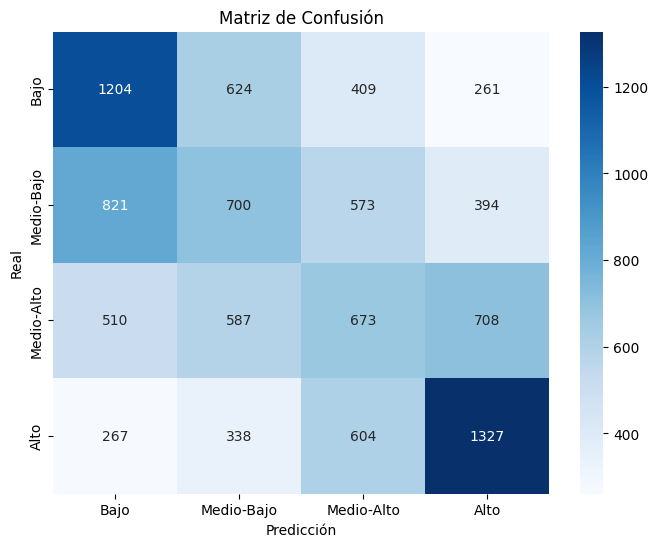


Análisis de errores por clase:
Bajo: 0.482 (2498 muestras)
Medio-Bajo: 0.281 (2488 muestras)
Medio-Alto: 0.272 (2478 muestras)
Alto: 0.523 (2536 muestras)


In [13]:
# Predicciones en el conjunto de validación
y_pred = best_svm.predict(X_val_selected)

# Métricas de evaluación
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy en validación: {accuracy:.4f}")

# Reporte de clasificación detallado
clases = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
print("\nReporte de clasificación:")
print(classification_report(y_val, y_pred, target_names=clases))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clases, yticklabels=clases)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Análisis de errores por clase
print("\nAnálisis de errores por clase:")
for i, clase in enumerate(clases):
    mask = y_val == i
    if mask.sum() > 0:
        accuracy_clase = (y_val[mask] == y_pred[mask]).mean()
        print(f"{clase}: {accuracy_clase:.3f} ({mask.sum()} muestras)")

## 9. Entrenamiento del modelo final

Entrenamos el modelo con todos los datos de entrenamiento para hacer predicciones en test.


In [14]:
print("Entrenando modelo final con todos los datos de entrenamiento disponibles...")

# CORRECCIÓN: Usar los datos ya procesados y submuestreados
# NO usar X, y originales que tienen NaN
print(f"Usando datos ya procesados:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Combinar train y validation para el modelo final
print("\n🔄 Combinando train y validation para entrenamiento final...")
X_full_processed = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_full_processed = pd.concat([y_train, y_val], axis=0, ignore_index=True)

print(f"Datos combinados: {X_full_processed.shape}")
print(f"Distribución final de clases:")
print(y_full_processed.value_counts(normalize=True).sort_index())

# Aplicar selección de características (ya fue ajustado en sección 6)
print(f"\n🎯 Aplicando selección de {best_k} características...")
X_full_selected = selector_final.transform(X_full_processed)
print(f"Datos finales para entrenamiento: {X_full_selected.shape}")

# Entrenar el modelo final con los mejores parámetros
print(f"\n🤖 Entrenando modelo final...")
import time
start_time = time.time()

modelo_final = SVC(**grid_search.best_params_, random_state=42)
modelo_final.fit(X_full_selected, y_full_processed)

end_time = time.time()
training_time = end_time - start_time
print(f"⏱️ Tiempo de entrenamiento: {training_time:.1f} segundos")

# Evaluar en el conjunto completo (como verificación)
train_accuracy = modelo_final.score(X_full_selected, y_full_processed)
print(f"✅ Accuracy en conjunto completo procesado: {train_accuracy:.4f}")

print(f"\n📊 RESUMEN DEL MODELO FINAL:")
print(f"   • Muestras de entrenamiento: {X_full_selected.shape[0]:,}")
print(f"   • Características seleccionadas: {X_full_selected.shape[1]}")
print(f"   • Parámetros: {modelo_final.get_params()}")
print(f"   • Accuracy: {train_accuracy:.4f}")

print("\n✅ Modelo final entrenado exitosamente")

Entrenando modelo final con todos los datos de entrenamiento disponibles...
Usando datos ya procesados:
X_train shape: (50000, 668)
X_val shape: (10000, 668)

🔄 Combinando train y validation para entrenamiento final...
Datos combinados: (60000, 668)
Distribución final de clases:
RENDIMIENTO_GLOBAL
0    0.249800
1    0.248783
2    0.247817
3    0.253600
Name: proportion, dtype: float64

🎯 Aplicando selección de 200 características...
Datos finales para entrenamiento: (60000, 200)

🤖 Entrenando modelo final...
⏱️ Tiempo de entrenamiento: 2013.7 segundos
✅ Accuracy en conjunto completo procesado: 0.5588

📊 RESUMEN DEL MODELO FINAL:
   • Muestras de entrenamiento: 60,000
   • Características seleccionadas: 200
   • Parámetros: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose

## 10. Carga y preprocesamiento de datos de test

In [22]:
print("Cargando y procesando datos de test...")

# Cargar datos de test
df_test = pd.read_csv("test.csv")
print(f"Datos de test - Filas: {df_test.shape[0]}, Columnas: {df_test.shape[1]}")

# Guardar IDs para el archivo de submission
test_ids = df_test['ID'].copy()

# Aplicar el mismo preprocesado que al entrenamiento
df_test_procesado = preprocesar_datos(df_test, es_train=False, scaler=scaler_entrenamiento)

print(f"Datos de test procesados - Filas: {df_test_procesado.shape[0]}, Columnas: {df_test_procesado.shape[1]}")

# Remover ID si existe
if 'ID' in df_test_procesado.columns:
    df_test_procesado = df_test_procesado.drop('ID', axis=1)

# Asegurar que test tenga las mismas columnas que train
missing_cols = set(X.columns) - set(df_test_procesado.columns)
extra_cols = set(df_test_procesado.columns) - set(X.columns)

if missing_cols:
    print(f"\nColumnas faltantes en test: {len(missing_cols)}")
    for col in missing_cols:
        df_test_procesado[col] = 0

if extra_cols:
    print(f"\nColumnas extra en test: {len(extra_cols)}")
    df_test_procesado = df_test_procesado.drop(columns=list(extra_cols))

# Reordenar columnas
df_test_procesado = df_test_procesado[X.columns]

print(f"\nDatos de test finales: {df_test_procesado.shape}")

Cargando y procesando datos de test...
Datos de test - Filas: 296786, Columnas: 20
Aplicando imputación de valores nulos...
Procesando horas de trabajo...
Procesando valor matrícula...
Procesando estrato vivienda...
Procesando variables binarias...
Aplicando label encoding ordenado...
Aplicando one-hot encoding para departamentos...
Procesando programas académicos...
Procesando periodo...
Aplicando normalización...
Preprocesado completado. Shape final: (296786, 678)
Datos de test procesados - Filas: 296786, Columnas: 678

Columnas extra en test: 9

Datos de test finales: (296786, 668)


## 11. Verificación y Limpieza de datos test

In [23]:
print("=== VERIFICACIÓN Y LIMPIEZA DE DATOS DE TEST ===")

# Verificar NaN en datos de test
print(f"📊 Verificando datos de test:")
print(f"Shape: {df_test_procesado.shape}")

total_nan = df_test_procesado.isnull().sum().sum()
print(f"Total NaN en test: {total_nan}")

if total_nan > 0:
    print(f"\n🔧 LIMPIANDO NaN EN DATOS DE TEST...")
    
    # Mostrar columnas con NaN
    nan_cols = df_test_procesado.columns[df_test_procesado.isnull().any()].tolist()
    print(f"Columnas con NaN: {nan_cols}")
    
    # Imputación robusta para test
    from sklearn.impute import SimpleImputer
    
    # Identificar tipos de columnas
    numeric_cols = df_test_procesado.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_test_procesado.select_dtypes(include=['object']).columns.tolist()
    
    # Imputar numéricas con mediana
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='median')
        df_test_procesado[numeric_cols] = numeric_imputer.fit_transform(df_test_procesado[numeric_cols])
        print(f"✅ Imputadas {len(numeric_cols)} columnas numéricas")
    
    # Imputar categóricas con moda
    if categorical_cols:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df_test_procesado[categorical_cols] = categorical_imputer.fit_transform(df_test_procesado[categorical_cols])
        print(f"✅ Imputadas {len(categorical_cols)} columnas categóricas")
    
    # Imputación final de emergencia
    final_nan = df_test_procesado.isnull().sum().sum()
    if final_nan > 0:
        print(f"🚨 Quedan {final_nan} NaN - aplicando imputación de emergencia...")
        emergency_imputer = SimpleImputer(strategy='constant', fill_value=0)
        df_test_procesado = pd.DataFrame(
            emergency_imputer.fit_transform(df_test_procesado),
            columns=df_test_procesado.columns,
            index=df_test_procesado.index
        )

# Verificar infinitos
inf_count = np.isinf(df_test_procesado.select_dtypes(include=[np.number])).sum().sum()
if inf_count > 0:
    print(f"🔧 Limpiando {inf_count} valores infinitos...")
    numeric_columns = df_test_procesado.select_dtypes(include=[np.number]).columns
    df_test_procesado[numeric_columns] = df_test_procesado[numeric_columns].replace([np.inf, -np.inf], [1e10, -1e10])

# Verificación final
final_nan_count = df_test_procesado.isnull().sum().sum()
final_inf_count = np.isinf(df_test_procesado.select_dtypes(include=[np.number])).sum().sum()

print(f"\n✅ VERIFICACIÓN FINAL DE TEST:")
print(f"NaN restantes: {final_nan_count}")
print(f"Infinitos restantes: {final_inf_count}")
print(f"Shape final: {df_test_procesado.shape}")

if final_nan_count == 0 and final_inf_count == 0:
    print("🎉 ¡Datos de test listos para predicción!")
else:
    print("❌ ERROR: Aún hay problemas en los datos")

print("="*50)

=== VERIFICACIÓN Y LIMPIEZA DE DATOS DE TEST ===
📊 Verificando datos de test:
Shape: (296786, 668)
Total NaN en test: 76710

🔧 LIMPIANDO NaN EN DATOS DE TEST...
Columnas con NaN: ['ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']
✅ Imputadas 668 columnas numéricas

✅ VERIFICACIÓN FINAL DE TEST:
NaN restantes: 0
Infinitos restantes: 0
Shape final: (296786, 668)
🎉 ¡Datos de test listos para predicción!


## 11. Predicciones en datos de test

In [ ]:
print("=== SUBMUESTREO DE TEST PARA DESARROLLO RÁPIDO ===")

# Usar solo una muestra del test para desarrollo
USE_TEST_SAMPLE = False  # Cambiar a False para submission final
TEST_SAMPLE_SIZE = 10000  # Solo 10k muestras en lugar de 296k

if USE_TEST_SAMPLE and df_test_procesado.shape[0] > TEST_SAMPLE_SIZE:
    print(f"🔥 MODO DESARROLLO: Reduciendo test de {df_test_procesado.shape[0]} a {TEST_SAMPLE_SIZE}")
    
    # Submuestreo aleatorio simple
    sample_indices = np.random.choice(
        df_test_procesado.shape[0], 
        size=TEST_SAMPLE_SIZE, 
        replace=False
    )
    
    # Aplicar submuestreo
    df_test_procesado_sample = df_test_procesado.iloc[sample_indices].copy()
    test_ids_sample = test_ids.iloc[sample_indices].copy()
    
    print(f"✅ Test reducido: {df_test_procesado_sample.shape}")
    print(f"✅ IDs reducidos: {len(test_ids_sample)}")
    
    # Reemplazar variables
    df_test_procesado = df_test_procesado_sample
    test_ids = test_ids_sample
    
    print(f"⚡ Tiempo estimado de predicción: 30 segundos vs 5+ minutos")
else:
    print(f"📊 Usando test completo: {df_test_procesado.shape[0]} muestras")
    print(f"⚠️ Tiempo estimado: 5+ minutos")

print(f"Shape final para predicciones: {df_test_procesado.shape}")

=== SUBMUESTREO DE TEST PARA DESARROLLO RÁPIDO ===
🔥 MODO DESARROLLO: Reduciendo test de 296786 a 10000
✅ Test reducido: (10000, 668)
✅ IDs reducidos: 10000
⚡ Tiempo estimado de predicción: 30 segundos vs 5+ minutos
Shape final para predicciones: (10000, 668)


In [24]:
print("Realizando predicciones en datos de test...")

# Aplicar selección de características al test
X_test_selected = selector_final.transform(df_test_procesado)
print(f"Test después de selección de características: {X_test_selected.shape}")

# Realizar predicciones
predicciones_numericas = modelo_final.predict(X_test_selected)

# Convertir predicciones numéricas a texto
mapeo_inverso = {
    0: 'bajo',
    1: 'medio-bajo', 
    2: 'medio-alto',
    3: 'alto'
}

predicciones_texto = [mapeo_inverso[pred] for pred in predicciones_numericas]

# Verificar distribución de predicciones
print("\nDistribución de predicciones:")
pred_counts = pd.Series(predicciones_texto).value_counts()
for clase, count in pred_counts.items():
    porcentaje = (count / len(predicciones_texto)) * 100
    print(f"{clase}: {count} ({porcentaje:.1f}%)")

print(f"\nTotal de predicciones: {len(predicciones_texto)}")
print(f"Total de IDs de test: {len(test_ids)}")

Realizando predicciones en datos de test...
Test después de selección de características: (296786, 200)

Distribución de predicciones:
alto: 80560 (27.1%)
bajo: 80338 (27.1%)
medio-bajo: 70065 (23.6%)
medio-alto: 65823 (22.2%)

Total de predicciones: 296786
Total de IDs de test: 296786


## 12. Generación del archivo de submission

In [25]:
print("Generando archivo de submission...")

# Crear DataFrame de submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': predicciones_texto
})

# Verificar formato del submission
print("\nPrimeras 10 filas del submission:")
print(submission.head(10))

print(f"\nVerificación del submission:")
print(f"Número de filas: {len(submission)}")
print(f"Columnas: {list(submission.columns)}")
print(f"Valores únicos en RENDIMIENTO_GLOBAL: {submission['RENDIMIENTO_GLOBAL'].unique()}")

# Verificar que no hay valores nulos
nulos_submission = submission.isnull().sum()
print(f"\nValores nulos en submission:")
print(nulos_submission)

# Guardar archivo
nombre_archivo = "submission_svm.csv"
submission.to_csv(nombre_archivo, index=False)
print(f"\nArchivo guardado como: {nombre_archivo}")

# Verificación final
verificacion = pd.read_csv(nombre_archivo)
print(f"\nVerificación final - archivo tiene {len(verificacion)} filas")
print("¡Submission generado exitosamente!")

Generando archivo de submission...

Primeras 10 filas del submission:
       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545               alto
2  499179               alto
3  782980               bajo
4  785185               bajo
5   58495               bajo
6  705444         medio-alto
7  557548               alto
8  519909               bajo
9  832058               alto

Verificación del submission:
Número de filas: 296786
Columnas: ['ID', 'RENDIMIENTO_GLOBAL']
Valores únicos en RENDIMIENTO_GLOBAL: ['bajo' 'alto' 'medio-alto' 'medio-bajo']

Valores nulos en submission:
ID                    0
RENDIMIENTO_GLOBAL    0
dtype: int64

Archivo guardado como: submission_svm.csv

Verificación final - archivo tiene 296786 filas
¡Submission generado exitosamente!


## 13. Resumen del modelo y conclusiones

In [26]:
print("=" * 60)
print("RESUMEN DEL MODELO SVM")
print("=" * 60)

print(f"\n📊 DATOS:")
print(f"   • Entrenamiento: {df_train.shape[0]:,} muestras")
print(f"   • Test: {df_test.shape[0]:,} muestras")
print(f"   • Características originales: {df_train.shape[1] - 1}")
print(f"   • Características después de preprocesado: {X.shape[1]}")
print(f"   • Características seleccionadas: {best_k}")

print(f"\n🔧 PREPROCESADO APLICADO:")
print(f"   • Imputación de valores nulos")
print(f"   • Encoding de variables categóricas")
print(f"   • One-hot encoding para alta cardinalidad")
print(f"   • Normalización con StandardScaler")
print(f"   • Selección de {best_k} mejores características")

print(f"\n🤖 MODELO:")
print(f"   • Algoritmo: Support Vector Machine (SVM)")
print(f"   • Mejores parámetros: {grid_search.best_params_}")
print(f"   • Accuracy en validación cruzada: {grid_search.best_score_:.4f}")
print(f"   • Accuracy en conjunto de validación: {val_score:.4f}")

print(f"\n📈 DISTRIBUCIÓN DE PREDICCIONES:")
for clase, count in pred_counts.items():
    porcentaje = (count / len(predicciones_texto)) * 100
    print(f"   • {clase.capitalize()}: {count:,} ({porcentaje:.1f}%)")

print(f"\n💡 CARACTERÍSTICAS MÁS IMPORTANTES:")
for i, (_, row) in enumerate(top_features.head(5).iterrows()):
    print(f"   {i+1}. {row['Feature']}: {row['Score']:.2f}")

print(f"\n✅ FORTALEZAS DEL MODELO:")
print(f"   • SVM es robusto con alta dimensionalidad")
print(f"   • Selección de características reduce overfitting")
print(f"   • Grid search optimiza hiperparámetros")
print(f"   • Validación cruzada estratificada")

print(f"\n⚠️ LIMITACIONES Y MEJORAS FUTURAS:")
print(f"   • Considerar ensemble methods")
print(f"   • Explorar feature engineering adicional")
print(f"   • Análisis más profundo de outliers")
print(f"   • Técnicas de balanceo de clases")

print(f"\n📁 ARCHIVO GENERADO: {nombre_archivo}")
print("=" * 60)

RESUMEN DEL MODELO SVM

📊 DATOS:
   • Entrenamiento: 692,500 muestras
   • Test: 296,786 muestras
   • Características originales: 11
   • Características después de preprocesado: 668
   • Características seleccionadas: 200

🔧 PREPROCESADO APLICADO:
   • Imputación de valores nulos
   • Encoding de variables categóricas
   • One-hot encoding para alta cardinalidad
   • Normalización con StandardScaler
   • Selección de 200 mejores características

🤖 MODELO:
   • Algoritmo: Support Vector Machine (SVM)
   • Mejores parámetros: {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}
   • Accuracy en validación cruzada: 0.3904
   • Accuracy en conjunto de validación: 0.3904

📈 DISTRIBUCIÓN DE PREDICCIONES:
   • Alto: 80,560 (27.1%)
   • Bajo: 80,338 (27.1%)
   • Medio-bajo: 70,065 (23.6%)
   • Medio-alto: 65,823 (22.2%)

💡 CARACTERÍSTICAS MÁS IMPORTANTES:
   1. FAMI_EDUCACIONMADRE: 1471.98
   2. FAMI_ESTRATOVIVIENDA: 1300.48
   3. FAMI_EDUCACIONPADRE: 1192.10
   4. ESTU_PAGOMATRICULAPROPIO: 715.08
 